In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d.axes3d import get_test_data
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pymongo
from pymongo import MongoClient
import datetime
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
pip install pymongo

Note: you may need to restart the kernel to use updated packages.


In [4]:
timeSeriesData = pd.DataFrame(columns=['symbol','date','cur_price','trade_quantity','updown_rate'])
timeSeriesCountData = pd.DataFrame(columns=['symbol','date','count'])

In [5]:

client = MongoClient('mongodb://127.0.0.1:27017/')
db = client['mph']
collection_price = db['crypto_prices']
collection_agg = db['token_aggs']

In [6]:
price_data = collection_price.find({'symbol':'OMG'})
agg_data = collection_agg.find({'symbol':'OMG'})
#data = collection.find()
print(agg_data)
index = 0

In [7]:
for price_detail in price_data:
    timeSeriesData.loc[index, 'symbol'] = price_detail['symbol']
    timeSeriesData.loc[index,'date']= price_detail['date']
    timeSeriesData.loc[index, 'cur_price'] = price_detail['cur_price']
    timeSeriesData.loc[index, 'trade_quantity'] = price_detail['trade_quantity']
    timeSeriesData.loc[index, 'updown_rate'] = price_detail['updown_rate']
    index+=1

index1 = 0

for agg_detail in agg_data:
    timeSeriesCountData.loc[index1, 'symbol'] = agg_detail['symbol']
    timeSeriesCountData.loc[index1,'date']= datetime.datetime.strptime(str(agg_detail['date']),'%Y%m%d')
    timeSeriesCountData.loc[index1, 'count'] = agg_detail['count']/18 # nomarlization
    index1+=1


timeSeriesData = timeSeriesData.sort_values(['date'])
timeSeriesCountData = timeSeriesCountData.sort_values(['date'])

In [8]:
print(timeSeriesData)
print(timeSeriesCountData)

    symbol                 date cur_price trade_quantity updown_rate
702    OMG  2018-01-01 00:00:00     19.18        3560000       -2.14
701    OMG  2018-01-02 00:00:00     20.13        4750000        4.95
700    OMG  2018-01-03 00:00:00     20.56        2370000        2.14
699    OMG  2018-01-04 00:00:00     19.66        2300000       -4.38
698    OMG  2018-01-05 00:00:00     18.59        2160000       -5.44
..     ...                  ...       ...            ...         ...
4      OMG  2019-11-30 00:00:00    0.7668        3450000       -4.44
3      OMG  2019-12-01 00:00:00    0.7472        3300000       -2.57
2      OMG  2019-12-02 00:00:00    0.7354        1830000       -1.58
1      OMG  2019-12-03 00:00:00    0.7433        1770000        1.09
0      OMG  2019-12-04 00:00:00    0.7279        2340000       -2.08

[703 rows x 5 columns]
    symbol                 date      count
1      OMG  2017-07-28 00:00:00  0.0555556
0      OMG  2017-08-06 00:00:00   0.111111
4      OMG  2017-08

/Users/hongminpyo/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


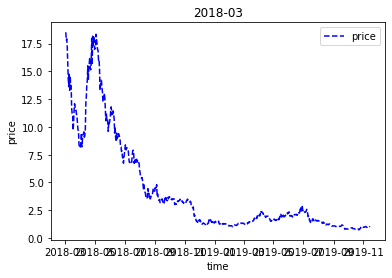

In [9]:
startDate1 = "2018-03-02"
endDate1 = "2019-11-15"

startDate = datetime.datetime.strptime(startDate1,"%Y-%m-%d")
endDate = datetime.datetime.strptime(endDate1,"%Y-%m-%d")

monthDate = startDate +pd.DateOffset(months=3)
###########################################################
# train을 위한 시계열 범위를 19년 4월 부터 6월 31일까지 1개 분기로 정함
###########################################################
timeSeriesData1 = timeSeriesData.loc[(timeSeriesData['date'] >= startDate) & (timeSeriesData['date'] <= endDate), :]
timeSeriesCountData1 = timeSeriesCountData.loc[(timeSeriesCountData['date'] >= startDate) & (timeSeriesCountData['date'] <= monthDate), :]

plt.plot(timeSeriesData1['date'].values, timeSeriesData1['cur_price'].values,'b--')
#plt.plot(timeSeriesCountData1['date'].values, timeSeriesCountData1['count'].values, 'ro')
plt.title(startDate.strftime('%Y-%m'))
plt.xlabel('time')
plt.ylabel('price')
plt.legend(['price','lift','downhill'])
plt.show()

/Users/hongminpyo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


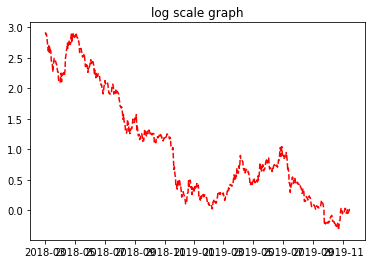

In [10]:
timeSeriesData1['log_price'] = np.log(np.array(timeSeriesData1['cur_price'],dtype=np.float32))

plt.plot(timeSeriesData1['date'].values, timeSeriesData1['log_price'].values, 'r--')
plt.title('log scale graph')
plt.show()

<Figure size 432x288 with 0 Axes>

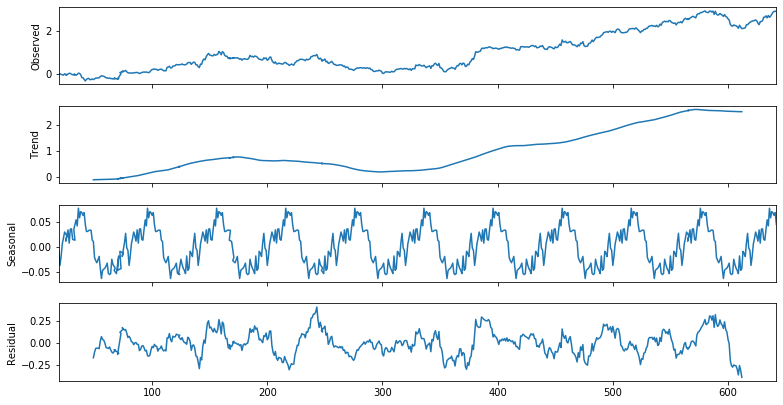

In [11]:
decompostion = seasonal_decompose(timeSeriesData1.log_price,freq=60)
fig = plt.figure()
fig = decompostion.plot()
fig.set_size_inches(12,6)

In [12]:
# 0 과 2 사이에서  p, d, q를 선언  
p = d= q = range(0,2)

In [13]:
# 가능한 모든 다른 조합을 만들어 냄 
pdq = list(itertools.product(p,d,q))

In [14]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [15]:
seasonal_pdq = [(x[0],x[1],x[2],60) for x in list(itertools.product(p,d,q))]

In [16]:
seasonal_pdq

[(0, 0, 0, 60),
 (0, 0, 1, 60),
 (0, 1, 0, 60),
 (0, 1, 1, 60),
 (1, 0, 0, 60),
 (1, 0, 1, 60),
 (1, 1, 0, 60),
 (1, 1, 1, 60)]

In [17]:
warnings.filterwarnings("ignore")

In [121]:
for param in pdq :
    for param_seasonal in seasonal_pdq :
        try :
            mod = sm.tsa.statespace.SARIMAX(timeSeriesData1.log_price,
                                           order = param ,
                                           trend = 't',
                                           seasonal_order = param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA {} x {} - AIC:{}'.format(param,param_seasonal,results.aic))
        except : 
            print('exception')
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 60) - AIC:2053.499273120945
ARIMA (0, 0, 0) x (0, 0, 1, 60) - AIC:1276.7895368458699
ARIMA (0, 0, 0) x (0, 1, 0, 60) - AIC:734.1093766129044
ARIMA (0, 0, 0) x (0, 1, 1, 60) - AIC:651.3121663474915
ARIMA (0, 0, 0) x (1, 0, 0, 60) - AIC:519.9665159459241
ARIMA (0, 0, 0) x (1, 0, 1, 60) - AIC:525.8424227817954
ARIMA (0, 0, 0) x (1, 1, 0, 60) - AIC:659.8990117784666
ARIMA (0, 0, 0) x (1, 1, 1, 60) - AIC:657.5796164194307
ARIMA (0, 0, 1) x (0, 0, 0, 60) - AIC:1233.953697778516
ARIMA (0, 0, 1) x (0, 0, 1, 60) - AIC:602.815312458742
ARIMA (0, 0, 1) x (0, 1, 0, 60) - AIC:103.28500976249
ARIMA (0, 0, 1) x (0, 1, 1, 60) - AIC:111.48623550970935
ARIMA (0, 0, 1) x (1, 0, 0, 60) - AIC:-101.1088061750519
ARIMA (0, 0, 1) x (1, 0, 1, 60) - AIC:-215.92488704041585
ARIMA (0, 0, 1) x (1, 1, 0, 60) - AIC:105.63519018029723
ARIMA (0, 0, 1) x (1, 1, 1, 60) - AIC:102.45700665628735
ARIMA (0, 1, 0) x (0, 0, 0, 60) - AIC:-1782.722888609353
ARIMA (0, 1, 0) x (0, 0, 1, 60) - AIC:-1654

In [20]:
mod = sm.tsa.statespace.SARIMAX(timeSeriesData1.log_price,
                               order=(0,0,1),
                               seasonal_order=(1,0,0,60),
                               trend='t',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          log_price   No. Observations:                  624
Model:             SARIMAX(0, 0, 1)x(1, 0, 0, 60)   Log Likelihood                  54.554
Date:                            Thu, 19 Dec 2019   AIC                           -101.109
Time:                                    21:51:55   BIC                            -83.769
Sample:                                         0   HQIC                           -94.340
                                            - 624                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0002   5.54e-05     -3.189      0.001      -0.000   -6.81e-05
ma.L1          0.8624      0.024   

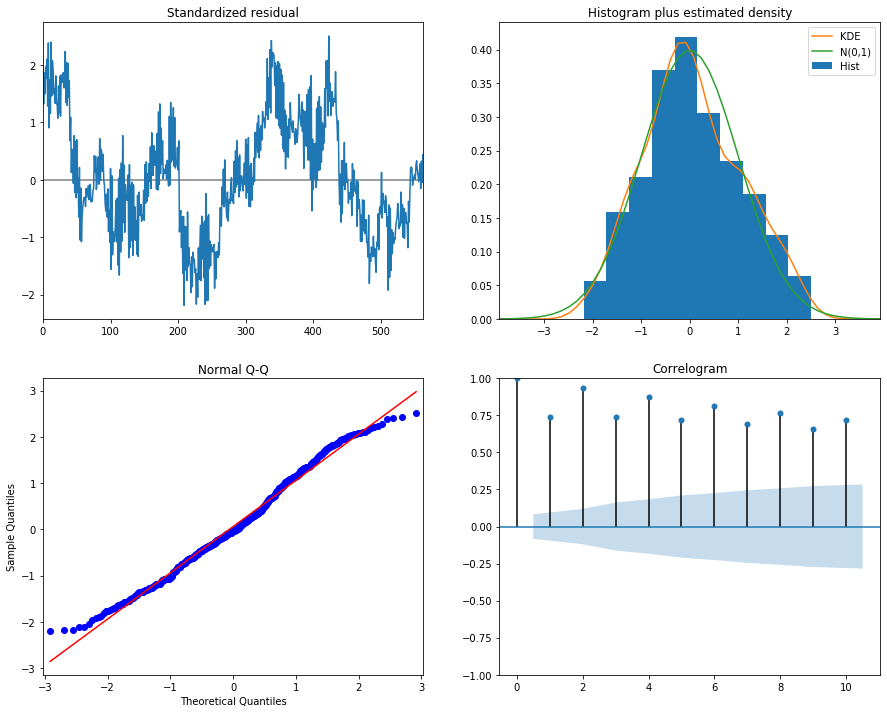

In [21]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

In [22]:
timeSeriesData1['forecast'] = results.predict(start=503, end=643,dynamic = True)+1.5

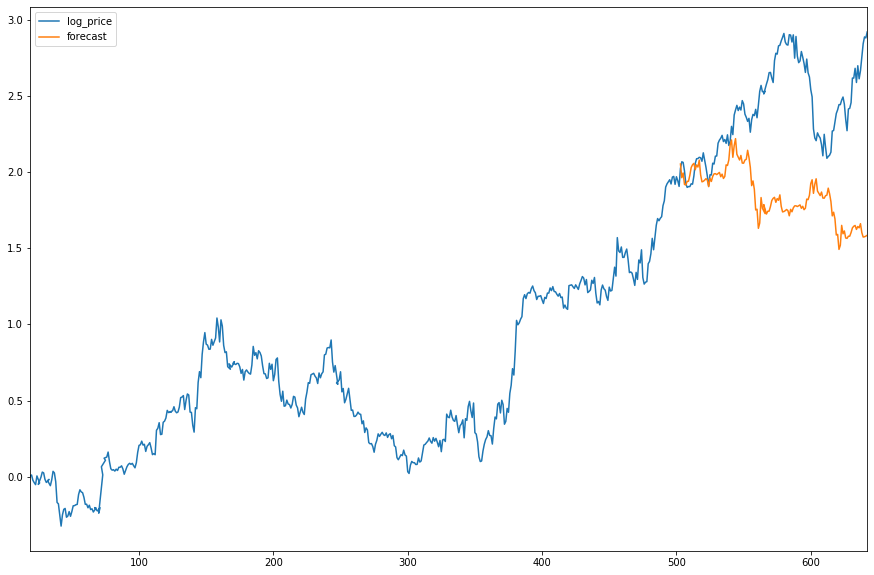

In [23]:
timeSeriesData1[['log_price','forecast']].plot(figsize=(15,10))